# 模型
 此模型主要由基础网络组成，其后是几个多尺度特征块。
 
 **基本网络**用于从输入图像中提取特征，因此它可以使用深度卷积神经网络。
 
 接下来的每个**多尺度特征块**将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。
 
 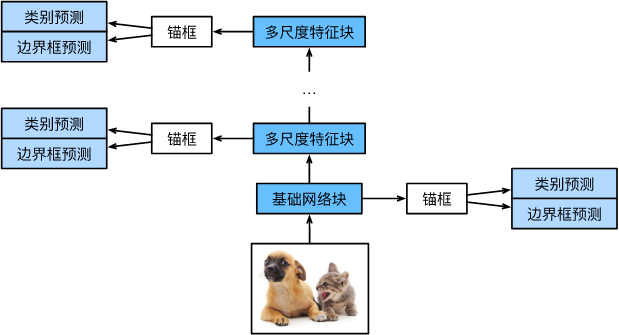

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 类别预测层
特征图宽高为h、w,以每个单元为中心生成a个锚框,需要对hwa个锚框进行分类,采用卷积层进行分类降低模型复杂度.
设目标类别为q,则需要标记q+1个锚框,其中第0个是背景,而输出通道数为a(q+1)

In [2]:
# 类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes):
#     num_anchors是a, num_classes是q
#     使用3*3卷积宽高不变
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

边界框预测层类似类别预测层,为每个锚框预测4个偏移量，而不是q+1个类别。

In [3]:
# 边界框预测层
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

我们为同一个小批量构建两个不同比例（Y1和Y2）的特征图，其中Y2的高度和宽度是Y1的一半。 以类别预测为例，假设Y1和Y2的每个单元分别生成了5个和3个锚框。 进一步假设目标类别的数量为10，对于特征图Y1和Y2，类别预测输出中的通道数分别为5*(10+1)=55和3*(10+1)=33，其中任一输出的形状是（批量大小，通道数，高度，宽度）。

In [4]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。 为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式,即将

In [5]:
def flatten_pred(pred):
#     permute是变换维度
#     flatten是展平
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)